# Notebook 5: Use GraphStorm APIs for Graph Prediction

Graph prediction, such as classification and regression, is a common task in Graph Machine Learning (GML) across various domains, including life sciences and chemistry. In graph prediction, the entire graph data is typically organized into batches of subgraphs, where each subgraph's nodes have edges only within the subgraph and no edges connecting to nodes in other subgraphs. GML labels are linked to these subgraphs. And then GML model makes prediction on new subgraphs as well.

A typical operation used in graph prediction is called `Read-out`, e.g., `sum`, `mean`, or `max/min`, which aggregates the representations of nodes in a subgraph to form one representation for the subgraph. Outputs of the `Read-out` will be further used to perform downstream prediction computation.

<img src="../../../../tutorial/GP_readout.png" style="margin:auto" width="400"/>

The current version of GraphStorm can not directly perform graph prediction. But as GraphStorm supports node-level prediction, we can use a method called `supernode` to fulfill the graph prediction requirement.

----

## `super-node` Method Explanation

Instead of using the `Read-out` operation, we add a new node, called **super node**, to each subgraph, and link all original nodes of the subgraph to it, but not adding reversed edges. With this method, representations of all original nodes could be easily aggregated to the **super node**. And then we can use the **super node** as the repsentation of this subgraph to perform graph level prediciton tasks. By using the `super-node` method, we turn the graph prediction task into a node prediction task.

<img src="../../../../tutorial/GP_supernode.png" style="margin:auto" width="300"/>

----

## Implementation Ideas

In order to use the `super-node` method in GraphStorm, we need to implement two extra functions.

- **Raw Graph Data Processing**: Add a super node to each subgraph in the original batch of subgraphs data, and store all of them as one heterogenous graph ready for GraphStorm's graph construction CLIs.
- **Customized GNN Encoder** (Optional): Create a customized GNN encoder for specific aggregation method for **super nodes**. This is an optional function as all built-in GraphStorm GNN encoders can aggregate and generate embeddings for **super nodes** naturally. But creating a customized GNN encoder could have fine-granular control of aggregation methods, which might minic the `Read-out` method.

This notebook will demonstrate the `super-node` method by using GraphStorm APIs and other libraries to implement both functions. 

This notebook serves as an example of a Graph Classification Solution using GrahpStorm APIs. Users can modify the customer GNN model and implement their own version.

---

## 1. Raw Graph Data Processing

In this notebook, we use the [OGBN Molhiv Data](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol), which is a popular graph property prediction dataset. Although the code below is for the `ogbn-molhiv` data, users can modify it for the other [OGBG datasets](https://ogb.stanford.edu/docs/graphprop/).

<div class="alert alert-block alert-info">
<b>Tip:</b> We also provide a tool to generate synthetic supernode-based graph data, which is avaible <a href="https://github.com/awslabs/graphstorm/blob/main/docs/source/api/notebooks/dummy_gc_data.py"><u>here</u></a>.</div>

With the converted molhiv raw data tables, we run GraphStorm's gconstruct command and partition the graph into one partition. The processed graph is stored in `/supernode_ogbg/`.


## 2. Customized RGCN Encoder Module Using Conv Layers

The key component of this super-node based solution is the modification of the GNN model that can perform message passing and aggregation in each subgraph, then perform sorts of "read-out" operation in the super nodes, and finally perform classification on those super-nodes.

This option uses GraphStorm's [RelGraphConvLayer](https://graphstorm.readthedocs.io/en/latest/generated/graphstorm.model.RelGraphConvLayer.html#graphstorm.model.RelGraphConvLayer) API as one of the input arguments, and implement an customzied RGCN model for graph classification task.

Using this option, users can change the graph conv layer type, hence forming different GCN models.

## 3. Training and Inference Pipeline

With the customized RGCN model modified for graph classification, we can reuse GraphStorm's end-to-end training and inference pipeline to conduct the graph classification task on our dummy data.

In [1]:
import logging
logging.basicConfig(level=20)

import graphstorm as gs
gs.initialize()

/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
ogbg_data = gs.dataloading.GSgnnData(part_config='./supernode_ogbg/supernode_ogbg.json')

INFO:root:Start to load partition from ./supernode_ogbg/part0/graph.dgl which is 110126629 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.


In [3]:
# define dataloaders for training, validation, and testing
nfeats_4_modeling = {'node': ['n_feat'], 'super': ['n_feat']}

train_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_train_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[20, 20, 20],
    batch_size=128,
    train_task=True)
val_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_val_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[100, 100, 100],
    batch_size=256,
    train_task=False)
test_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_test_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[100, 100, 100],
    batch_size=256,
    train_task=False)


INFO:root:part 0, train 32901
INFO:root:part 0, val 4113
INFO:root:part 0, test 4113


In [4]:
import torch as th
from graphstorm.model import (GSgnnNodeModel,
                              GSNodeEncoderInputLayer,
                              RelationalGCNEncoder,
                              RelationalGATEncoder,
                              HGTEncoder,
                              EntityClassifier,
                              ClassifyLossFunc)
from graphstorm.model.gnn_encoder_base import GraphConvEncoder

class GCNEncoder4SupernodeOgbg(GraphConvEncoder):
    r"""A graph conv encoder for Graph Classification

        Unique arguments in this class:
        -------------------------------
        base_encoder: GraphStorm ConvEncoder types, options:
            1. `RelationalGCNEncoder`;
            2. `RelationalGATEncoder`;
            3. `HGTEncoder`.
        read_out_opt: string in the following options:
            The aggregation method for the cached supernodes' representations. The current options:
            1. `last_only`: only use the last layer's representations. If use this option, 
               the read_out_ops will be ignored because there is only one layer representation
               is involved in the final read_out.
            2. `mean`: compute the mean of all of the cached supernode representations.
            3. `sum`: compute the summantion of all of the cached supernode representations.
            4. `weighted_sum`: use additional weight parameters to compute the weighted summation
               all of the cached supernode representations.
            5. `min`: compute the minimum in each dimension of the all of the cached supernode
               representations.
            6. `max`: compute the maximum in each dimension of the all of the cached supernode
               representations.
        super_ntype: string
            The name of supernode. Default is 'super'.

    """
    def __init__(self,
                 h_dim,
                 out_dim,
                 base_encoder,
                 read_out_opt='last_only',
                 super_ntype='super'
                ):
        assert isinstance(base_encoder, (RelationalGCNEncoder, RelationalGATEncoder, HGTEncoder)), \
               'Only support GraphStorm\'s RelationalGCNEncoder, RelationalGATEncoder, and HGTEncoder'
        assert base_encoder.num_layers >= 3, 'For Graph Classification task, at least two layers GNN' + \
                                       f'encoder required, but got {num_hidden_layers} ...'
        super(GCNEncoder4SupernodeOgbg, self).__init__(h_dim, out_dim, base_encoder.num_layers)

        assert read_out_opt in ['last_only', 'mean', 'sum', 'weighted_sum', 'min', 'max'], + \
                                f'Not recognized read_out_opt {read_out_opt}. Options include ' + \
                                '\'last_only\', \'mean\', \'sum\', \'weighted_sum\', \'mim\', ' + \
                                'and \'max\'.'
        self.base_encoder = base_encoder
        self.read_out_opt = read_out_opt
        self.super_ntype = super_ntype
        if read_out_opt=='weighted_sum':
            self.weighted_sum_para = th.nn.Parameter(th.Tensor(1, num_hidden_layers))

    def forward(self, blocks, h):

        supernode_cache = []

        # message passing in subgraphs and cache super-nodes representations
        for layer, block in zip(self.base_encoder.layers, blocks):
            h = layer(block, h)

            # 1. cache the output of supernodes in each layer
            supernode_cache.append(h[self.super_ntype])
            # 2. zero out the representations of supernodes as the next layer input
            h[self.super_ntype] = th.zeros_like(h[self.super_ntype])

        # add final read_out functions.
        supernode_cache = th.stack(supernode_cache)
        output = self._read_out_ops(supernode_cache)

        return {self.super_ntype: output}

    def _read_out_ops(self, supernode_cache):
        """ The supernode_cache shape L * N * D
            The output shape N * D
        """
        if self.read_out_opt=='last_only':
            output = supernode_cache[-1]
        elif self.read_out_opt=='mean':
            output = th.mean(supernode_cache, dim=0)
        elif self.read_out_opt=='sum':
            output = th.sum(supernode_cache, dim=0)
        elif self.read_out_opt=='weighted_sum':
            output = th.einsum('ij, jkl->kl', self.weighted_sum_para, supernode_cache)

        return output


In [5]:
class RgcnNCModel4SuperOgbg(GSgnnNodeModel):
    """ A customized RGCN model for node classification using Graphstorm APIs

    This model just replace the `RelationalGCNEncoder` with our customized `GCNEncoder4SupernodeOgbg`.

    Arguments
    ----------
    g: DistGraph
        A DGL DistGraph.
    num_hid_layers: int
        The number of gnn layers.
    node_feat_field: dict of list of strings
        The list features for each node type to be used in the model.
    hid_size: int
        The dimension of hidden layers.
    num_classes: int
        The target number of classes for classification.
    multilabel: boolean
        Indicator of if this is a multilabel task.
    """
    def __init__(self,
                 g,
                 num_hid_layers,
                 node_feat_field,
                 hid_size,
                 num_classes,
                 multilabel=False):
        super(RgcnNCModel4SuperOgbg, self).__init__(alpha_l2norm=0.)

        # extract feature size
        feat_size = gs.get_node_feat_size(g, node_feat_field)

        # set an input layer encoder
        encoder = GSNodeEncoderInputLayer(g=g, feat_size=feat_size, embed_size=hid_size)
        self.set_node_input_encoder(encoder)

        # set the customized GCNEncoder4SupernodeOgbg as the GNN encoder
        gnn_encoder = RelationalGCNEncoder(g=g,
                                           h_dim=hid_size,
                                           out_dim=hid_size,
                                           num_hidden_layers=num_hid_layers)
        # wrap base gcn encoder into GCNEncoder4GC
        gp_encoder = GCNEncoder4SupernodeOgbg(hid_size,
                                              hid_size,
                                              gnn_encoder,
                                              read_out_opt='last_only',
                                              super_ntype='super')
        self.set_gnn_encoder(gp_encoder)

        # set a decoder specific to node classification task
        decoder = EntityClassifier(in_dim=hid_size,
                                   num_classes=num_classes,
                                   multilabel=multilabel)
        self.set_decoder(decoder)

        # classification loss function
        self.set_loss_func(ClassifyLossFunc(multilabel=multilabel))

        # initialize model's optimizer
        self.init_optimizer(lr=0.001,
                            sparse_optimizer_lr=0.001,
                            weight_decay=0)


In [6]:
model = RgcnNCModel4SuperOgbg(g=ogbg_data.g,
                              num_hid_layers=3,
                              node_feat_field=nfeats_4_modeling,
                              hid_size=128,
                              num_classes=2)

In [7]:
# setup a classification evaluator for the trainer
evaluator = gs.eval.GSgnnClassificationEvaluator(eval_frequency=100,
                                                 eval_metric_list=['roc_auc'])

In [8]:
# create a GraphStorm node task trainer for the RGCN model
trainer = gs.trainer.GSgnnNodePredictionTrainer(model)
trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

In [9]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=50,
            save_model_path='a_save_path/')

INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 1.1843 | Time: 0.0540
INFO:root:Part 0 | Epoch 00000 | Batch 020 | Loss: 0.2184 | Time: 0.0302
INFO:root:Part 0 | Epoch 00000 | Batch 040 | Loss: 0.1207 | Time: 0.0343
INFO:root:Part 0 | Epoch 00000 | Batch 060 | Loss: 0.2150 | Time: 0.0375
INFO:root:Part 0 | Epoch 00000 | Batch 080 | Loss: 0.1894 | Time: 0.0319
INFO:root:Step 100 | Train loss: 0.0947
INFO:root:Step 100 | Validation roc_auc: 0.5802
INFO:root:Step 100 | Test roc_auc: 0.6496
INFO:root:Step 100 | Best Validation roc_auc: 0.5802
INFO:root:Step 100 | Best Test roc_auc: 0.6496
INFO:root:Step 100 | Best Iteration roc_auc: 100.0000
INFO:root: Eval time: 1.6069, Evaluation step: 100.
INFO:root:Part 0 | Epoch 00000 | Batch 100 | Loss: 0.2084 | Time: 0.0334
INFO:root:Part 0 | Epoch 00000 | Batch 120 | Loss: 0.1379 | Time: 0.0503
INFO:root:Part 0 | Epoch 00000 | Batch 140 | Loss: 0.1684 | Time: 0.0326
INFO:root:Part 0 | Epoch 00000 | Batch 160 | Loss: 0.1765 | Time: 0.0374
INFO:ro

Next, we examine the model performance over the training process

In [10]:
# Extract accuracies from the trainer's evaluator:
val_accs, test_accs = [], []
for val_acc, test_acc in trainer.evaluator.history:
    val_accs.append(val_acc['roc_auc'])
    test_accs.append(test_acc['roc_auc'])

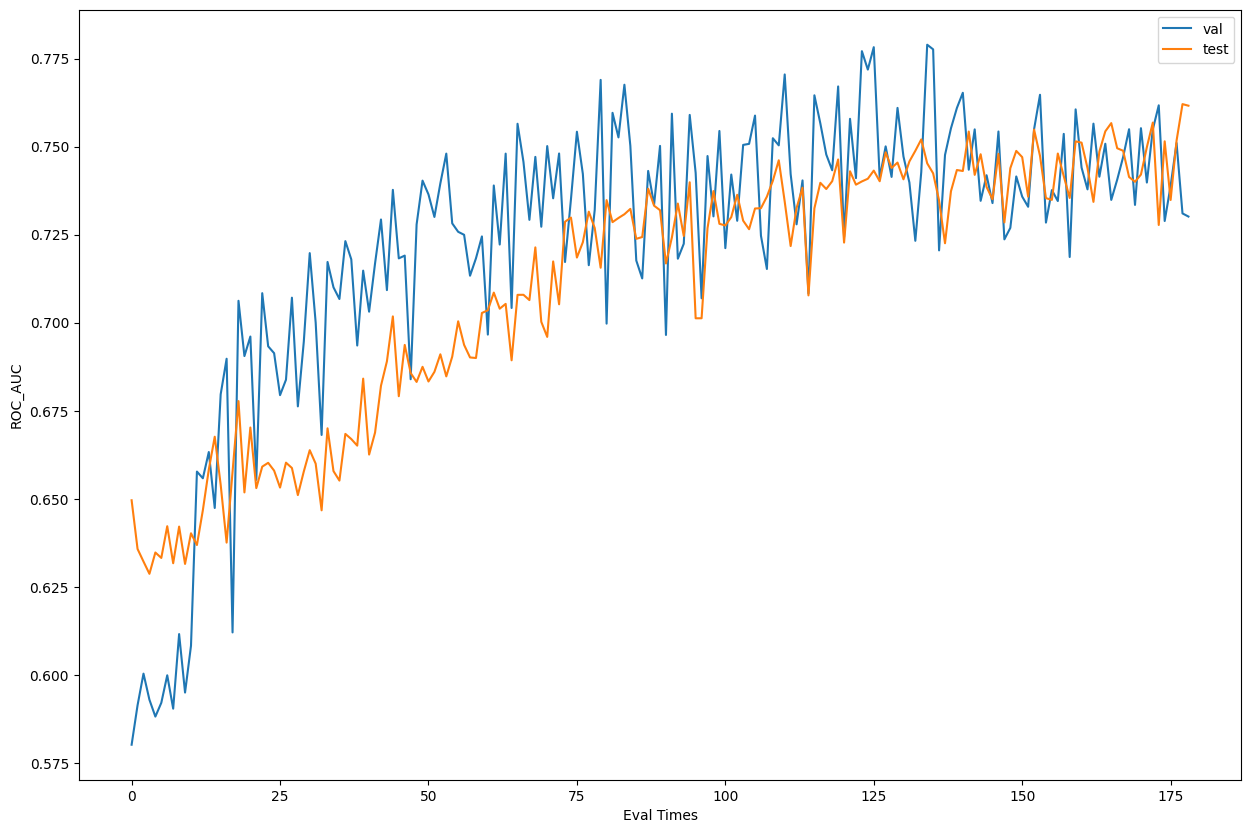

In [11]:
import matplotlib.pyplot as plt

# plot the learning curves
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(val_accs, label='val')
ax.plot(test_accs, label='test')
ax.set(xlabel='Eval Times', ylabel='ROC_AUC')
ax.legend(loc='best');

In [12]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model checkpoint:', best_model_path)

Best model checkpoint: a_save_path/epoch-37


In [13]:
# check the saved artifacts
!ls -ls {best_model_path}

total 2372
 792 -rw-rw-r-- 1 ec2-user ec2-user  808835 Sep  9 17:53 model.bin
1580 -rw-rw-r-- 1 ec2-user ec2-user 1617186 Sep  9 17:53 optimizers.bin


### 3. Inference with the trained model

In [14]:
# we can restore the model from the checkpoint:
model.restore_model(best_model_path)

INFO:root:successfully load the model from a_save_path/epoch-37
INFO:root:Time on load model: 0.006 seconds


In [15]:
# Setup dataloader for inference
infer_dataloader = gs.dataloading.GSgnnNodeDataLoader(dataset=ogbg_data,
                                                      target_idx=ogbg_data.get_node_test_set(ntypes=['super']),
                                                      node_feats=nfeats_4_modeling,
                                                      label_field='labels',
                                                      fanout=[100, 100, 100],
                                                      batch_size=256,
                                                      train_task=False)

INFO:root:part 0, test 4113


In [16]:
# Create an Inferrer object
infer = gs.inference.GSgnnNodePredictionInferrer(model)

# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

INFO:root:save embeddings pf super to infer/embeddings
INFO:root:Writing GNN embeddings to infer/embeddings in pytorch format.


In [17]:
# The GNN embeddings on the inference graph are saved to:
!ls -lh {best_model_path}/infer/embeddings

ls: cannot access a_save_path/epoch-37/infer/embeddings: No such file or directory


In [18]:
!ls -lh {best_model_path}/infer/predictions

ls: cannot access a_save_path/epoch-37/infer/predictions: No such file or directory
